### Import Required Packages and Set Options

In [1]:
import os
import sys
# import git

import numpy as np
import numba as nb
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# warnings.filterwarnings("ignore", category=nb.NumbaPerformanceWarning)

In [2]:
sns.set_style('whitegrid')
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
# plt.rcParams

#### Dynamically Re-Load all Package Modules

In [3]:
%load_ext autoreload
%autoreload 2

from rankfm.rankfm import RankFM
from rankfm.evaluation import hit_rate, reciprocal_rank, discounted_cumulative_gain, precision, recall, diversity

### Load Example Data

#### Load Interactions Data
* `interactions` must be a `pd.dataframe` or `np.ndarray` with columns: `[user_id, item_id]` when used for model fitting
* the rows of `interactions` should represent observed or implied positive feedback for the user/item pair
* examples of implicit feedback include product purchases, movie/article views, page views, clicks, etc.
* the `user_id` and/or `item_id` identifiers can be arbitrary integers or even strings as long as they are unique identifiers for users/items
* RankFM internally maps raw `user_id` and `item_id` values to zero-based index positions but maps all output back to original identifier values

* it is recommended you perform any cross-validation or data splitting strategy requiring additional columns prior to preparing the interaction data for model fitting

* in this example we'll assume all observed movie ratings count as positive implicit feedback regardless of numerical rating `[1-5]`

* this most closely represents the intended data and modeling context for which RankFM was designed (implicit preferences recommendation)

In [4]:
#Load data
path = "/Users/a420777/Desktop/hcc/gnn/datasets/movielens/"

In [5]:
#Ratings
interactions = pd.read_csv(path+'ratings.dat', sep='::', header=None, engine='python')
interactions.columns = ['user_id','item_id','rating','timestamp']
interactions = interactions.drop('timestamp', axis=1)

In [6]:
#Movies
item_names = pd.read_csv(path+'movies.dat', sep='::', header=None, engine='python')
item_names.columns = ['item_id','title','genres']

In [8]:
#Users
user_features = pd.read_csv(path+'users.dat', sep='::', header=None, engine='python')
user_features.columns = ['user_id','gender','age','occupation','zip-code']
user_features = user_features.drop('zip-code', axis=1)

In [9]:
# interactions = pd.read_csv(os.path.join(data_path, 'ML_1M_RATINGS.csv'))
interactions.head()

,user_id,item_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


#### Load User Features
* `user_features` must be a `pd.dataframe` or `np.ndarray` with columns: `[user_id, uf_1, ... , uf_n]`
* the first column must be the `user_id` and the set of `user_id` values must match the unique users found in `interactions`
* the additional columns should be user attributes/features that can be coerced to `float32` data type (i.e. no strings)
* care should be taken to scale any continuous features prior to model fitting for numerical stability - often dummy/tag features work best

In [12]:
# user_features = pd.read_csv(os.path.join(data_path, 'ML_1M_USERS.csv'))
user_features.occupation=user_features.occupation.astype("object")
user_features.age=user_features.age.astype("object")

In [13]:
user_features=pd.get_dummies(user_features)

#### Load Item Features
* `item_features` must be a `pd.dataframe` or `np.ndarray` with columns: `[item_id, uf_1, ... , uf_n]`
* the first column must be the `item_id` and the set of `item_id` values must match the unique items found in `interactions`
* the additional columns should be item attributes/features that can be coerced to `float32` data type (i.e. no strings)
* care should be taken to scale any continuous features prior to model fitting for numerical stability - often dummy/tag features work best

In [14]:
# https://datascience.stackexchange.com/questions/14847/multiple-categorical-values-for-a-single-feature-how-to-convert-them-to-binary-u
# https://datascience.stackexchange.com/questions/8253/how-to-binary-encode-multi-valued-categorical-variable-from-pandas-dataframe

In [15]:
import collections

In [18]:
split_series=item_names.genres.str.split("|").apply(lambda x: x)

In [19]:
split_series_dict=split_series.apply(collections.Counter)
multi_hot=pd.DataFrame.from_records(split_series_dict).fillna(value=0)

In [20]:
item_features=pd.concat([item_names.item_id, multi_hot], axis=1)

#### Load Item Names
* these won't be used for model fitting, but are important when reviewing the output for face validity
* also analyzing recommended/similar movies isn't any fun if you can't see the titles!

#### Check Matrix/Vector Dimensions

In [21]:
unique_users = interactions.user_id.nunique()
unique_items = interactions.item_id.nunique()

print("interactions shape: {}".format(interactions.shape))
print("interactions unique users: {}".format(interactions.user_id.nunique()))
print("interactions unique items: {}".format(interactions.item_id.nunique()))

print("user features users:", interactions.user_id.nunique())
print("item features items:", interactions.item_id.nunique())

interactions shape: (1000209, 3)
interactions unique users: 6040
interactions unique items: 3706
user features users: 6040
item features items: 3706


#### Evaluate Interaction Matrix Sparsity

In [22]:
sparsity = 1 - (len(interactions) / (unique_users * unique_items))
print("interaction matrix sparsity: {}%".format(round(100 * sparsity, 1)))

interaction matrix sparsity: 95.5%


#### Split Interactions Data into (Train, Valid) for Model Evaluation
* we'll randomly split off 25% of the observed user/item interactions for model validation
* take care to note any users/items in the validation set not appearing in the training set

* for model fitting we'll have to unify the set of users/items across `interactions`, `user_features`, `item_features`
* for scoring/recommendation RankFM has the `cold_start` option to either drop unseen users/items or set model output to np.nan

In [23]:
np.random.seed(1492)
interactions['random'] = np.random.random(size=len(interactions))
test_pct = 0.25

In [24]:
train_mask = interactions['random'] <  (1 - test_pct)
valid_mask = interactions['random'] >= (1 - test_pct)

interactions_train = interactions[train_mask][['user_id', 'item_id']]
interactions_valid = interactions[valid_mask][['user_id', 'item_id']]

train_users = np.sort(interactions_train.user_id.unique())
valid_users = np.sort(interactions_valid.user_id.unique())
cold_start_users = set(valid_users) - set(train_users)

train_items = np.sort(interactions_train.item_id.unique())
valid_items = np.sort(interactions_valid.item_id.unique())
cold_start_items = set(valid_items) - set(train_items)

print("train shape: {}".format(interactions_train.shape))
print("valid shape: {}".format(interactions_valid.shape))

print("train users: {}".format(len(train_users)))
print("valid users: {}".format(len(valid_users)))
print("cold-start users: {}".format(cold_start_users))

print("train items: {}".format(len(train_items)))
print("valid items: {}".format(len(valid_items)))
print("cold-start items: {}".format(cold_start_items))

train shape: (749724, 2)
valid shape: (250485, 2)
train users: 6040
valid users: 6038
cold-start users: set()
train items: 3666
valid items: 3531
cold-start items: {3202, 2563, 644, 3460, 3209, 3722, 139, 396, 651, 1555, 1434, 1915, 1830, 2217, 2218, 687, 1842, 2742, 1851, 2619, 576, 3321, 3277, 3323, 3280, 601, 3290, 3164, 989, 865, 226, 3172, 1386, 878, 3187, 758, 3065, 763, 2556, 127}


In [25]:
user_features = user_features[user_features.user_id.isin(train_users)]
item_features = item_features[item_features.item_id.isin(train_items)]
user_features.shape, item_features.shape

((6040, 31), (3666, 19))

### Fit the Model on the Training Data and Evaluate Out-of-Sample Performance Metrics

#### Initialize the Model Object

In [26]:
model = RankFM(factors=20, loss='warp', max_samples=20, alpha=0.01, sigma=0.1, learning_rate=0.10, learning_schedule='invscaling')
model

#### Fit the Model on the Training Data

* each epoch represents one full pass through all observed user/item interactions in the training data

* the `verbose` flag will print the current training epoch as well as the epoch's penalized log-likelihood value

* the training algorithm attempts to maximize the model's log likelihood which represents user preferences for observed items over unobserved items

* the log likelihood isn't 1:1 correlated with our recommendation/ranking evaluation metrics but serves as a decent proxy for training progress 

In [27]:
%%time
model.fit(interactions_train, epochs=20, verbose=True)


training epoch: 0
log likelihood: -434433.75

training epoch: 1
log likelihood: -420144.03125

training epoch: 2
log likelihood: -410680.4375

training epoch: 3
log likelihood: -405669.09375

training epoch: 4
log likelihood: -402369.28125

training epoch: 5
log likelihood: -400163.34375

training epoch: 6
log likelihood: -398232.21875

training epoch: 7
log likelihood: -396977.09375

training epoch: 8
log likelihood: -395550.78125

training epoch: 9
log likelihood: -394704.4375

training epoch: 10
log likelihood: -393696.75

training epoch: 11
log likelihood: -393200.71875

training epoch: 12
log likelihood: -392413.6875

training epoch: 13
log likelihood: -392190.46875

training epoch: 14
log likelihood: -391532.78125

training epoch: 15
log likelihood: -391579.0625

training epoch: 16
log likelihood: -391001.6875

training epoch: 17
log likelihood: -390895.0625

training epoch: 18
log likelihood: -390115.15625

training epoch: 19
log likelihood: -390569.1875
CPU times: user 33.5 s,

#### Generate Model Scores for Validation Interactions
* the `predict()` method generates real-valued model scores for user/item pairs
* specify scoring interactions or user/item pairs the same way as training: `[user_id, item_id]`
* the scores generated are those produced by the underlying second-degree factorization machine model
* the `cold_start` option allows you to either generate missing values for unseen users/items or drop them from scoring output

In [57]:
interactions_valid

,user_id,item_id
1,1,661
6,1,1287
7,1,2804
12,1,2398
16,1,2687
...,...,...
1000196,6040,549
1000197,6040,2020
1000203,6040,1090
1000204,6040,1091


In [28]:
valid_scores = model.predict(interactions_valid, cold_start='nan') 
print(valid_scores.shape)
pd.Series(valid_scores).describe()

(250485,)


count    250437.000000
mean          0.734158
std           0.917342
min          -3.192067
25%           0.095812
50%           0.725559
75%           1.373034
max           4.098247
dtype: float64

#### Generate TopN Recommendations for Validation Users
* instead of having to generate predictions for all user/item pairs the `recommend()` method lets you generate the topN recommended items for each user
* the output is a pd.dataframe where the index values are `user_id` and the columns are recommended items in descending order (first column is best item)
* additionally there's an option `filter_previous` to exclude any items already observed during training for the user from being recommended
* as with `predict()` there's a `cold_start` option to either fill with missing or drop recommendations for any user not found in training

In [59]:
valid_users

array([   1,    2,    3, ..., 6038, 6039, 6040])

In [70]:
dd=pd.DataFrame(data={"data":22},index={"1"})

In [73]:
dd.values

array([[22]])

In [75]:
model.recommend(dd.values[0])

,0,1,2,3,4,5,6,7,8,9
22,1580,2571,780,2628,480,589,1391,1517,1676,1196


In [29]:
valid_recommendations = model.recommend(valid_users, n_items=10, filter_previous=True, cold_start='nan')
valid_recommendations.head()

,0,1,2,3,4,5,6,7,8,9
1,1,364,34,318,2858,1704,2081,593,912,2396
2,527,1610,260,3418,733,590,150,377,1704,296
3,1197,1,2804,110,2791,2918,2028,2000,1387,2571
4,2571,1387,1210,1198,1196,858,924,2640,589,1221
5,2396,2336,2692,2599,223,3160,2318,2712,1041,2912


#### Evaluate Model Performance on the Validation Data

##### Specify Number of Recommended Items
* here we'll look at model performance in terms of validation metrics wrt the top 10 recommended items for each user
* it's good to compare validation metrics against the best unpersonalized recommendations: overall item popularity rankings from the training data

In [44]:
k = 10

##### Generate Pure-Popularity Baselines

In [31]:
most_popular = interactions_train.groupby('item_id')['user_id'].count().sort_values(ascending=False)[:k]
most_popular

item_id
2858    2545
260     2254
1196    2230
1210    2178
589     2002
2028    1980
480     1974
1270    1939
2571    1921
608     1910
Name: user_id, dtype: int64

In [32]:
test_user_items = interactions_valid.groupby('user_id')['item_id'].apply(set).to_dict()
test_user_items = {key: val for key, val in test_user_items.items() if key in set(train_users)}

base_hrt = np.mean([int(len(set(most_popular.index) & set(val)) > 0)                       for key, val in test_user_items.items()])
base_pre = np.mean([len(set(most_popular.index) & set(val)) / len(set(most_popular.index)) for key, val in test_user_items.items()])
base_rec = np.mean([len(set(most_popular.index) & set(val)) / len(set(val))                for key, val in test_user_items.items()])

print("number of test users: {}".format(len(test_user_items)))
print("baseline hit rate: {:.3f}".format(base_hrt))
print("baseline precision: {:.3f}".format(base_pre))
print("baseline recall: {:.3f}".format(base_rec))

number of test users: 6038
baseline hit rate: 0.635
baseline precision: 0.116
baseline recall: 0.046


##### Generate Model Validation Metrics
* the RankFM package comes with a number of utility functions to evaluate model performance
* these functions cover common validation metrics for recommendation/ranking models with implicit feedback data
* all evaluation functions have the same interface and require a previously fit RankFM model
    * `hit_rate`: the proportion of users with any relevant recommended item
    * `reciprocal_rank`: the inverse rank of the first relevant recommended item (or zero if no matches)
    * `discounted_cumulative_gain`: the sum of the inverse log-scaled ranks for relevant recommended items
    * `precision`: the number of relevant recommended items / number of recommended items
    * `recall`: the number of relevant recommended items / number of relevant items

In [45]:
def discounted_cumulative_gain(model, test_interactions, k=10, filter_previous=False):
    """evaluate discounted cumulative gain wrt out-of-sample observed interactions

    :param model: trained RankFM model instance
    :param test_interactions: pandas dataframe of out-of-sample observed user/item interactions
    :param k: number of recommendations to generate for each user
    :param filter_previous: remove observed training items from generated recommendations
    :return: mean discounted cumulative gain wrt the test users
    """

    # ensure that the model has been fit before attempting to generate predictions
    assert model.is_fit, "you must fit the model prior to evaluating hold-out metrics"

    # transform interactions into a user -> items dictionary
    test_user_items = pd.DataFrame(get_data(test_interactions), columns=['user_id', 'item_id'])
    test_user_items = test_user_items.groupby('user_id')['item_id'].apply(set).to_dict()
    test_users = list(test_user_items.keys())

    # generate topK recommendations for all test users also present in the training data
    test_recs = model.recommend(users=test_users, n_items=k, filter_previous=filter_previous, cold_start='drop')
    comm_user = test_recs.index.values

    # calculate the discounted cumulative gain (sum of inverse log scaled ranks of relevant items) wrt common users
    match_indexes = [np.where(test_recs.loc[u].isin(set(test_recs.loc[u]) & test_user_items[u]))[0] for u in comm_user]
    discounted_cumulative_gain = np.mean([np.sum(1 / np.log2(index + 2)) if len(index) > 0 else 0 for index in match_indexes])
    return discounted_cumulative_gain


In [33]:
%%time
model_hit_rate = hit_rate(model, interactions_valid, k=k)
model_reciprocal_rank = reciprocal_rank(model, interactions_valid, k=k)
model_dcg = discounted_cumulative_gain(model, interactions_valid, k=k)
model_precision = precision(model, interactions_valid, k=k)
model_recall = recall(model, interactions_valid, k=k)

CPU times: user 26.1 s, sys: 439 ms, total: 26.5 s
Wall time: 27 s


In [34]:
print("hit_rate: {:.3f}".format(model_hit_rate))
print("reciprocal_rank: {:.3f}".format(model_reciprocal_rank))
print("dcg: {:.3f}".format(model_dcg, 3))
print("precision: {:.3f}".format(model_precision))
print("recall: {:.3f}".format(model_recall))

hit_rate: 0.798
reciprocal_rank: 0.341
dcg: 0.733
precision: 0.159
recall: 0.077


#### Assess Recommendation Diversity
* in addition to relevance, it's often important to assess the diversity of model recommendations
* in other words, how many items are getting recommended overall, what's the percentage of users getting recommended the top items, etc.
* this is an important component of personalization - high diversity will help prevent the harmful rich-get-richer feedback loop over time

In [35]:
recommendation_diversity = diversity(model, interactions_valid, k=k)
recommendation_diversity.head(10)

,item_id,cnt_users,pct_users
0,2858,2532,0.419344
1,2571,1868,0.309374
2,2762,1635,0.270785
3,1580,1390,0.230209
4,260,1372,0.227228
5,1210,1303,0.215800
6,1196,1277,0.211494
7,527,1169,0.193607
8,608,1055,0.174727
9,2997,995,0.164790


In [36]:
top_items = pd.merge(item_names, recommendation_diversity, on='item_id', how='inner')
top_items = top_items.set_index('item_id').loc[recommendation_diversity.item_id].reset_index()
top_items = top_items[['item_id', 'cnt_users', 'pct_users', 'title', 'genres']]
top_items.head(10)

,item_id,cnt_users,pct_users,title,genres
0,2858,2532,0.419344,American Beauty (1999),Comedy|Drama
1,2571,1868,0.309374,"Matrix, The (1999)",Action|Sci-Fi|Thriller
2,2762,1635,0.270785,"Sixth Sense, The (1999)",Thriller
3,1580,1390,0.230209,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi
4,260,1372,0.227228,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
5,1210,1303,0.215800,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
6,1196,1277,0.211494,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
7,527,1169,0.193607,Schindler's List (1993),Drama|War
8,608,1055,0.174727,Fargo (1996),Crime|Drama|Thriller
9,2997,995,0.164790,Being John Malkovich (1999),Comedy


In [37]:
coverage = np.mean(recommendation_diversity['cnt_users'] > 0)
print("percentage of items recommended to at least one user: {:.3f}".format(coverage))

percentage of items recommended to at least one user: 0.206


In [38]:
nonzero_users = recommendation_diversity[recommendation_diversity.cnt_users > 0]
entropy = -np.sum(nonzero_users['pct_users'] * np.log2(nonzero_users['pct_users']))
print("entropy value of recommended items: {:.3f}".format(entropy))

entropy value of recommended items: 41.375


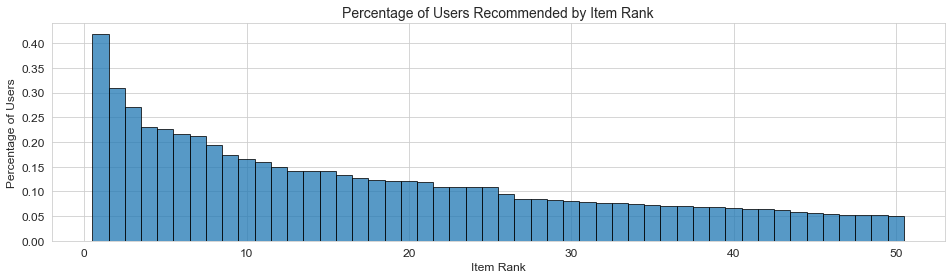

In [39]:
N = 50
fig, axes = plt.subplots(1, 1, figsize=[16, 4])

topN = recommendation_diversity.iloc[:N, :]
axes.bar(topN.index.values + 1, topN.pct_users, width=1, edgecolor='black', alpha=0.75)
axes.set(xlabel='Item Rank', ylabel='Percentage of Users', title='Percentage of Users Recommended by Item Rank')
plt.show()

### Calculate the Most Similar Items to a Given Item
* the model's representation of users/items in latent factor space allows for the calculation of item-item similarity with simple dot products
* in many contexts it's useful to serve similar items either for user acceptance or for contextual recommendations 
* one example might be recommending the user a list of movies to watch next after he/she has just finished watching a given movie

In [40]:
random_user = np.random.choice(interactions_valid.user_id.unique())
print("random user: {}".format(random_user))

random user: 467


In [50]:
item_names

,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [51]:
pd.merge(interactions[interactions.user_id==467], item_names, on="item_id")

,user_id,item_id,rating,random,title,genres
0,467,1250,1,0.681974,"Bridge on the River Kwai, The (1957)",Drama|War
1,467,1259,4,0.924251,Stand by Me (1986),Adventure|Comedy|Drama
2,467,587,4,0.969752,Ghost (1990),Comedy|Romance|Thriller
3,467,1,4,0.550595,Toy Story (1995),Animation|Children's|Comedy
4,467,3,4,0.027778,Grumpier Old Men (1995),Comedy|Romance
...,...,...,...,...,...,...
64,467,3751,3,0.827475,Chicken Run (2000),Animation|Children's|Comedy
65,467,1210,1,0.517528,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
66,467,2959,1,0.529030,Fight Club (1999),Drama
67,467,1092,5,0.591968,Basic Instinct (1992),Mystery|Thriller


In [41]:
random_user_recs = valid_recommendations.loc[random_user]
random_user_recs = item_names[item_names.item_id.isin(random_user_recs)].set_index('item_id').loc[random_user_recs]
random_user_recs

,title,genres
item_id,,
110,Braveheart (1995),Action|Drama|War
457,"Fugitive, The (1993)",Action|Thriller
2291,Edward Scissorhands (1990),Drama|Romance
2762,"Sixth Sense, The (1999)",Thriller
2028,Saving Private Ryan (1998),Action|Drama|War
1265,Groundhog Day (1993),Comedy|Romance
1704,Good Will Hunting (1997),Drama
539,Sleepless in Seattle (1993),Comedy|Romance
1307,When Harry Met Sally... (1989),Comedy|Romance


#### Look at Similar Movies for a Few of the User's Recommended Movies

In [53]:
most_similar_items = model.similar_items(227) #919
most_similar_items = item_names.set_index('item_id').loc[most_similar_items]
most_similar_items

,title,genres
item_id,,
1869,Black Dog (1998),Action|Thriller
990,Maximum Risk (1996),Action|Adventure|Thriller
208,Waterworld (1995),Action|Adventure
704,"Quest, The (1996)",Action|Adventure
2334,"Siege, The (1998)",Action|Thriller
204,Under Siege 2: Dark Territory (1995),Action
20,Money Train (1995),Action
1744,Firestorm (1998),Action|Adventure|Thriller
886,Bulletproof (1996),Action


In [43]:
most_similar_items = model.similar_items(2028)
most_similar_items = item_names.set_index('item_id').loc[most_similar_items]
most_similar_items

,title,genres
item_id,,
318,"Shawshank Redemption, The (1994)",Drama
110,Braveheart (1995),Action|Drama|War
1704,Good Will Hunting (1997),Drama
457,"Fugitive, The (1993)",Action|Thriller
2501,October Sky (1999),Drama
3147,"Green Mile, The (1999)",Drama|Thriller
527,Schindler's List (1993),Drama|War
1213,GoodFellas (1990),Crime|Drama
2762,"Sixth Sense, The (1999)",Thriller
